# 新宿を試す
新宿の交差点を定点カメラから14時から22時まで1分ごとに撮影した画像で物体検出を行う。

In [33]:
from ultralytics import YOLO

model = YOLO("yolov9c.pt")

### 物体検出後の数え上げ方

In [34]:
from collections import defaultdict
from enum import Enum


class ObjectType(Enum):
    """YOLOv9上で利用する番号の列挙型
    
    ex. `ObjectType.person.value` で　`0` が取得できる
    
    """
    person = 0
    bicycle = 1
    car = 2
    motorcycle = 3
    bus = 5
    truck = 7


def create_dict():
    return {h: 0 for h in range(14, 23)}

sum_dict: dict[str, dict[int, int]] = {
    ObjectType.person.name: create_dict(), 
    ObjectType.bicycle.name: create_dict(), 
    ObjectType.car.name: create_dict(), 
    ObjectType.motorcycle.name: create_dict(), 
    ObjectType.bus.name: create_dict(), 
    ObjectType.truck.name: create_dict()
}


# 1時間ごとに集計して合計値を辞書に格納する
h, m = 14, 0
for file_count in range(25, 566):
    if m == 60:
        m = 0
        h += 1

    persons, bicycles, cars, motorcycles, buses, trucks = 0, 0, 0, 0, 0, 0
    if h >= 14:
        results = model.predict(f"../data/pics/20210614_{str(file_count).zfill(4)}.jpg", save=True, exist_ok=True, conf=0.8)
        for target in results[0].boxes.cls:
            if int(target) == ObjectType.person.value:
                sum_dict[ObjectType.person.name][h] += 1
                persons += 1
            if int(target) == ObjectType.bicycle.value:
                sum_dict[ObjectType.bicycle.name][h] += 1
                bicycles += 1
            if int(target) == ObjectType.car.value:
                sum_dict[ObjectType.car.name][h] += 1
                cars += 1
            if int(target) == ObjectType.motorcycle.value:
                sum_dict[ObjectType.motorcycle.name][h] += 1
                motorcycles += 1
            if int(target) == ObjectType.bus.value:
                sum_dict[ObjectType.bus.name][h] += 1
                buses += 1
            if int(target) == ObjectType.truck.value:
                sum_dict[ObjectType.truck.name][h] += 1
                trucks += 1
    
        m += 1


image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\pics\20210614_0025.jpg: 384x640 (no detections), 808.4ms
Speed: 2.0ms preprocess, 808.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to F:\src\JPT\shibuya-scramble\runs\detect\predict

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\pics\20210614_0026.jpg: 384x640 (no detections), 671.6ms
Speed: 1.0ms preprocess, 671.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to F:\src\JPT\shibuya-scramble\runs\detect\predict

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\pics\20210614_0027.jpg: 384x640 1 car, 677.6ms
Speed: 2.0ms preprocess, 677.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to F:\src\JPT\shibuya-scramble\runs\detect\predict

image 1/1 F:\src\JPT\shibuya-scramble\notebooks\..\data\pics\20210614_0028.jpg: 384x640 (no detections), 669.6ms
Speed: 0.0ms preprocess, 669.6ms inference, 1.0ms postprocess per

## 20210614 新宿の概要

In [35]:
print(f"時間帯ごとの小計:")
for k, v in sum_dict.items():
    print(f"[{k:10}], {dict(v)}")
    print(f"[{k:10}の合計] {sum(v.values()):4}\t[1時間あたりの平均台数] {sum(v.values()) / len(v):7.2f}")


時間帯ごとの小計:
[person    ], {14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 2, 20: 1, 21: 0, 22: 0}
[person    の合計]    4	[1時間あたりの平均台数]    0.44
[bicycle   ], {14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0}
[bicycle   の合計]    0	[1時間あたりの平均台数]    0.00
[car       ], {14: 61, 15: 68, 16: 85, 17: 79, 18: 48, 19: 22, 20: 14, 21: 14, 22: 7}
[car       の合計]  398	[1時間あたりの平均台数]   44.22
[motorcycle], {14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0}
[motorcycleの合計]    0	[1時間あたりの平均台数]    0.00
[bus       ], {14: 30, 15: 22, 16: 25, 17: 29, 18: 18, 19: 5, 20: 9, 21: 5, 22: 0}
[bus       の合計]  143	[1時間あたりの平均台数]   15.89
[truck     ], {14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0}
[truck     の合計]    1	[1時間あたりの平均台数]    0.11


(0.0, 8.0)

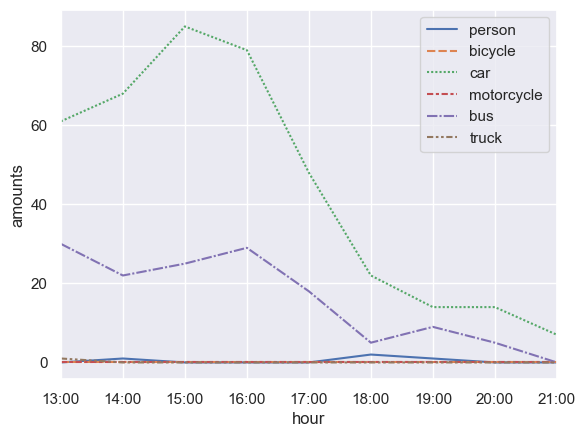

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

sns.set()

df = pd.DataFrame({k: v.values() for k, v in sum_dict.items()})
ax = sns.lineplot(data=df)

# 日本語の表示ができないため、英語を使う
ax.set_xlabel("hour")
ax.set_ylabel("amounts")

# 横軸を1時間刻みにして14-22時の間を表示する
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
ax.set_xticks(range(0, 11))
ax.set_xticklabels([f"{str(i)}:00" for i in range(13, 24)])
plt.xlim(0, 8)